# EXAMEN 2

Cada error u omisión en un ejercicio resta 0.5 puntos.

Cada código demás (que no se ha pedido) se interpretará como que no se está seguro de lo que se pide y resta 0.25 puntos.

In [1]:
import numpy as np

## EJERCICIO 1

El conjunto de datos cats_vs_dogs https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=es-419 es un conjunto de imágenes de perros y gatos.

Tienes que entrenar un modelo de redes convolucionales para que aprenda a clasificar entre perro y gato, pero no vamos a empezar de cero, vamos a usar alguna de las redes ya existentes: InceptionV3.

Tienes que seguir los siguientes pasos:
* Carga el conjunto de imágenes (entrenamiento, validación y pruebas)
* Explora los datos: número de elementos, número de clases, nombres de las clases y dibuja algunas imágenes con sus etiquetas...
* Prepara los datos: añade más elementos al conjunto de entrenamiento (rotando, trasladando... las imágenes actuales) y prepara los datos para el modelo.
* Entrena un modelo para estos datos usando InceptionV3 y muestra todas las capas del modelo.
* Busca una imagen en Internet y haz una predicción.

Puedes usar take(10) a la hora de entrenar aunque los resultados sean malísimos, con el fin de que no pierdas tiempo. Usa pocos epoch y añade como comentarios que valores pondrías realmente.

2025-02-17 16:57:57.921446: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 16:57:57.929431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 16:57:57.938631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 16:57:57.941258: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 16:57:57.949160: I tensorflow/core/platform/cpu_feature_guar

Total de imágenes: 23262
Número de clases: 2
Nombre de las clases: ['cat', 'dog']


2025-02-17 16:57:59.815134: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


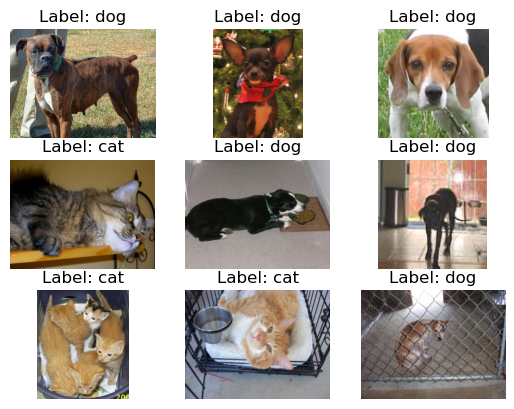

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load("cats_vs_dogs",split=["train[:80%]", "train[80%:90%]", "train[90%:]"], as_supervised=True, with_info=True)
train_set, valid_set, test_set = dataset

num_samples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names

print(f"Total de imágenes: {num_samples}")
print(f"Número de clases: {num_classes}")
print(f"Nombre de las clases: {class_names}")

for i, (image, label) in enumerate(train_set.take(9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())  # Convertimos a numpy para mostrar en matplotlib
        plt.title(f"Label: {class_names[label.numpy()]}")
        plt.axis("off")

In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),  
    tf.keras.layers.RandomZoom(0.2),  
    tf.keras.layers.RandomContrast(0.2),  
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)  
])

def augment_image(image, label):
    image = data_augmentation(image)
    return image, label

def preprocess_image(image, label):
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

train_set_preprocessed = train_set.map(preprocess_image)
train_set_augmented = train_set.map(preprocess_image).map(augment_image)
train_set_full = train_set_preprocessed.concatenate(train_set_augmented)
train_set_full = train_set_full.batch(32)

valid_set_preprocessed = valid_set.map(preprocess_image)
valid_set_augmented = valid_set.map(preprocess_image).map(augment_image)
valid_set_full = valid_set_preprocessed.concatenate(valid_set_augmented)
valid_set_full = valid_set_full.batch(32)

test_set_preprocessed = test_set.map(preprocess_image)
test_set_augmented = test_set.map(preprocess_image).map(augment_image)
test_set_full = test_set_preprocessed.concatenate(test_set_augmented)

In [4]:
model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [5]:
for layer in model.layers:
    layer.trainable = False

my_model = tf.keras.Sequential([
    model,                                 
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

my_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_model.fit(train_set_full.take(10), epochs=5, validation_data=valid_set_full.take(10))
# De normal usar todo el set y 20 epochs o lo necesario


Epoch 1/5


I0000 00:00:1739807884.761605   55123 service.cc:146] XLA service 0x73334c002400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739807884.761648   55123 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-02-17 16:58:04.855345: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-17 16:58:05.598172: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90100


 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4045 - loss: 0.7555

I0000 00:00:1739807894.133154   55123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5077 - loss: 0.6993

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 489ms/step - accuracy: 0.5370 - loss: 0.6784 - val_accuracy: 0.7063 - val_loss: 0.4802
Epoch 2/5
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7966 - loss: 0.4156

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8137 - loss: 0.4018 - val_accuracy: 0.9781 - val_loss: 0.2446
Epoch 3/5
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9842 - loss: 0.2061

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9842 - loss: 0.2027 - val_accuracy: 0.9844 - val_loss: 0.1710
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9853 - loss: 0.1484

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9855 - loss: 0.1471 - val_accuracy: 0.9844 - val_loss: 0.1312
Epoch 5/5
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9914 - loss: 0.1121

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9912 - loss: 0.1105 - val_accuracy: 0.9844 - val_loss: 0.1090


In [6]:
total_layers = len(model.layers)
unfreeze_layers = int(total_layers * 0.30)

for layer in model.layers[-unfreeze_layers:]:
    layer.trainable = True

my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_model.fit(train_set_full.take(10), epochs=5, validation_data=valid_set_full.take(10))

# Igual que antes habría que entrenar más epochs y con todo el set


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8759 - loss: 0.3025

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.8702 - loss: 0.3100 - val_accuracy: 0.9875 - val_loss: 0.0804
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9723 - loss: 0.1363

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9703 - loss: 0.1419 - val_accuracy: 0.9937 - val_loss: 0.0662
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9919 - loss: 0.0770

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9912 - loss: 0.0801 - val_accuracy: 0.9937 - val_loss: 0.0568
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0493

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 0.0511 - val_accuracy: 0.9969 - val_loss: 0.0498
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0345

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 0.0356 - val_accuracy: 0.9969 - val_loss: 0.0447


In [ ]:
img_path = "/home/iabd/VSCode/Python_clase/Exámenes/SAPA-2/Datos/dog_test.jpeg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
img_tensor = tf.keras.applications.inception_v3.preprocess_input(img_tensor)
img_tensor = tf.expand_dims(img_tensor, axis=0)
predictions = my_model.predict(img_tensor)

predicted_class = 'Dog' if predictions[0] > 0.5 else 'Cat'
print(f"Predicción: {predicted_class} con una probabilidad de {predictions[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicción: Dog con una probabilidad de 0.99


## EJERCICIO 2

Tienes que detectar cuantos coches cruzan la línea. Tienes el video origen (trafico.mp4) así como el video de como quiero que quede (trafico_resultado.mp4), fíjate las etiquetas de los objetos y donde está la línea para contar los objetos.

Tienes que guardar en un archivo .mp4 el video que se crear y tienes que escribir en la terminal el marcador final.

In [20]:
from ultralytics.solutions.solutions import BaseSolution
from ultralytics.utils.plotting import Annotator, colors
import csv
from datetime import datetime
import os
import cv2

class ObjectCounter(BaseSolution):
    """
    A class to manage the counting of objects in a real-time video stream based on their tracks.

    This class extends the BaseSolution class and provides functionality for counting objects moving in and out of a
    specified region in a video stream. It supports both polygonal and linear regions for counting.

    Attributes:
        in_count (int): Counter for objects moving inward.
        out_count (int): Counter for objects moving outward.
        counted_ids (List[int]): List of IDs of objects that have been counted.
        saved_ids (List[int]): List of IDs of objects that have been saved to the CSV file.
        classwise_counts (Dict[str, Dict[str, int]]): Dictionary for counts, categorized by object class.
        region_initialized (bool): Flag indicating whether the counting region has been initialized.
        show_in (bool): Flag to control display of inward count.
        show_out (bool): Flag to control display of outward count.
    """

    def __init__(self, **kwargs):
        """Initializes the ObjectCounter class for real-time object counting in video streams."""
        super().__init__(**kwargs)

        self.in_count = 0  # Contador para objetos que se acercan
        self.out_count = 0  # Contador para objetos que se alejan
        self.counted_ids = []  # Lista para IDs de los objetos ya contados
        self.saved_ids = []  # Lista de IDs ya guardados en el csv
        self.classwise_counts = {}  # Diccionario de conteo, categorizado
        self.region_initialized = False  # Booleno para inicialización de región

        self.show_in = self.CFG.get("show_in", True)
        self.show_out = self.CFG.get("show_out", True)

    def save_label_to_csv(self, track_id, label, action):
        """Save the label, track_id, action, and current time to a new CSV file with the current date."""
        if track_id in self.saved_ids:
            return  # Ignora guardar el ID si ya está en la lista

        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        current_date = datetime.now().strftime("%Y-%m-%d")  # Fecha actual en el formato correcto

        # Crea nombre del fichero con la fecha actual
        filename = f'tracked_objects_{current_date}.csv'

        # Comprueba que exista el fichero, si existe escribe otro nombre
        file_exists = os.path.isfile(filename)

        with open(filename, mode='a', newline='') as file:
            writer = csv.writer(file)

            # Si no existe el fichero escribe headers
            if not file_exists:
                writer.writerow(['track_id', 'label', 'action', 'date', 'time'])

            # Escribe en la columna de datos con el ID actual
            writer.writerow([track_id, label, action, current_time.split()[0], current_time.split()[1]])
            self.saved_ids.append(track_id)  # Marca el ID como guardado

    def count_objects(self, current_centroid, track_id, prev_position, cls):
        """
        Counts objects within a polygonal or linear region based on their tracks.

        Args:
            current_centroid (Tuple[float, float]): Current centroid values in the current frame.
            track_id (int): Unique identifier for the tracked object.
            prev_position (Tuple[float, float]): Last frame position coordinates (x, y) of the track.
            cls (int): Class index for classwise count updates.
        """
        if prev_position is None or track_id in self.counted_ids:
            return

        action = None  # Por defecto es None

        if len(self.region) == 2:  # Region lineal
            line = self.LineString(self.region)
            if line.intersects(self.LineString([prev_position, current_centroid])):
                if abs(self.region[0][0] - self.region[1][0]) < abs(self.region[0][1] - self.region[1][1]):
                    if current_centroid[0] > prev_position[0]:  # Movimiento derecha
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Movimiento izquierda
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                else:
                    if current_centroid[1] > prev_position[1]:  # Movimiento abajo
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Movimiento arriba
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                self.counted_ids.append(track_id)

        elif len(self.region) > 2:  # Region poligonal
            polygon = self.Polygon(self.region)
            if polygon.contains(self.Point(current_centroid)):
                region_width = max([p[0] for p in self.region]) - min([p[0] for p in self.region])
                region_height = max([p[1] for p in self.region]) - min([p[1] for p in self.region])

                if region_width < region_height:
                    if current_centroid[0] > prev_position[0]:  # Movimiento derecha
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Movimiento izquierda
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                else:
                    if current_centroid[1] > prev_position[1]:  # Movimiento abajo
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Movimiento arriba
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                self.counted_ids.append(track_id)

        # Guarda la etiqueta y la acción
        if action:
            label = f"{self.names[cls]} ID: {track_id}"
            self.save_label_to_csv(track_id, label, action)

    def store_classwise_counts(self, cls):
        """Initialize class-wise counts for a specific object class if not already present."""
        if self.names[cls] not in self.classwise_counts:
            self.classwise_counts[self.names[cls]] = {"IN": 0, "OUT": 0}

    def display_counts(self, im0):
        """Displays object counts on the input image or frame."""
        labels_dict = {
            str.capitalize(key): f"{'IN ' + str(value['IN']) if self.show_in else ''} "
            f"{'OUT ' + str(value['OUT']) if self.show_out else ''}".strip()
            for key, value in self.classwise_counts.items()
            if value["IN"] != 0 or value["OUT"] != 0
        }

        if labels_dict:
            self.annotator.display_analytics(im0, labels_dict, (104, 31, 17), (255, 255, 255), 10)

        for track_id in self.track_ids:
            if track_id in self.counted_ids:
                in_count = self.in_count
                label = f"ID:{track_id} count at number {in_count}"
                self.annotator.box_label(self.boxes[self.track_ids.index(track_id)], label=label, color=(255, 255, 0))

    def count(self, im0):
        """Processes input data (frames or object tracks) and updates object counts."""
        if not self.region_initialized:
            self.initialize_region()
            self.region_initialized = True

        self.annotator = Annotator(im0, line_width=self.line_width)
        self.extract_tracks(im0)
        self.annotator.draw_region(reg_pts=self.region, color=(104, 0, 123), thickness=self.line_width * 2)

        for box, track_id, cls in zip(self.boxes, self.track_ids, self.clss):
            self.store_tracking_history(track_id, box)
            self.store_classwise_counts(cls)

            label = f"{self.names[cls]} ID: {track_id}"
            self.annotator.box_label(box, label=label, color=colors(cls, True))

            current_centroid = ((box[0] + box[2]) / 2, (box[1] + box[3]) / 2)
            prev_position = self.track_history[track_id][-2] if len(self.track_history[track_id]) > 1 else None
            self.count_objects(current_centroid, track_id, prev_position, cls)

        self.display_counts(im0)
        self.display_output(im0)

        return im0

# Función para el tracking del ratón
def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:  # Comprueba que se mueva el ratón
        point = [x, y]
        print(f"Mouse moved to: {point}")

# Abrir el video
cap = cv2.VideoCapture('/home/iabd/VSCode/Python_clase/Exámenes/SAPA-2/Datos/trafico.mp4')

# Define región para contar
region_points = [(280, 255), (735, 255)] # La mitad del video a ojo

# Inicializa el contador
counter = ObjectCounter(
    region=region_points,  # Pasar los puntos de la región
    model="yolo11s.pt",  # Modelo que cuente objetos
    classes=[2,7],  # Fijar la detección de clases a coches (2) y camiones (7)
    show_in=True,  # Enseñar contador de entradas
    show_out=True,  # Enseñar contador de salidas
    line_width=2,  # Adjustar ancho de linea para el output
)

# Crear una ventana con nombre y activar detección de ratón
cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

count = 0

while True:
    # Leer fotograma del video
    ret, frame = cap.read()
    if not ret:
        break
        # Si el video se acaba, comenzar desde el principio
#        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
#        continue
    count += 1
    if count % 2 != 0:  # Saltar fotogramas impares
        continue

    frame = cv2.resize(frame, (1020, 500))

    # Procesar el fotograma con el contador de objetos
    frame = counter.count(frame)

    # Enseñar el fotograma
    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):  # Pulsar q para salir
        break

# Liberar el capturador de video y cerrar la ventana
cap.release()
cv2.destroyAllWindows()



Ultralytics Solutions: ✅ {'region': [(280, 255), (735, 255)], 'show_in': True, 'show_out': True, 'colormap': None, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'json_file': None, 'records': 5, 'model': 'yolo11s.pt', 'classes': [2, 7], 'line_width': 2}



0: 320x640 14 cars, 2 trucks, 4.7ms
Speed: 0.8ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 14 cars, 2 trucks, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Mouse moved to: [356, 261]
Mouse moved to: [363, 283]

0: 320x640 14 cars, 2 trucks, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)
Mouse moved to: [375, 334]

0: 320x640 13 cars, 2 trucks, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Mouse moved to: [379, 363]
Mouse moved to: [381, 367]

0: 320x640 12 cars, 2 trucks, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)
Mouse moved to: [392, 386]
Mouse moved to: [393, 388]

0: 320x640 9 cars, 2 trucks, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Mouse moved to

## EJERCICIO 3
A partir de los datos proporcionados:
* Crea dos conjuntos de datos: train y test
* Crea el modelo que tienes en la imagen modelo.png
* Muestra en una imagen el modelo creado.
* Entrena el modelo probando diferentes tasas de aprendizaje usando detención temprana y evalúa cada modelo en el conjunto de test (en el entrenamiento indica que tiene que coger el 5% para el conjunto de validación).
* Guarda el modelo cuya media de las métricas de las tres salidas en el conjunto de test sea la mejor.
* Indica cuál es la tasa de aprendizaje del modelo elegido.

In [ ]:
# Generar datos artificiales
np.random.seed(42)
X = np.random.rand(5000, 15) * 15  # 5000 muestras con 15 características entre 0 y 15
X1 = X[:, :10]  # Primera entrada con 10 características
X2 = X[:, 5:]  # Segunda entrada con 10 características solapadas

# Agregar ruido aleatorio a Y
noise = np.random.normal(0, 0.1, (5000, 3))
Y1 = np.sin(np.sum(X1, axis=1)) + np.cos(np.sum(X2, axis=1)) + noise[:, 0]
Y2 = np.tanh(np.prod(X1, axis=1) * np.prod(X2, axis=1)) + noise[:, 1]
Y3 = np.log1p(np.mean(X1, axis=1) + np.mean(X2, axis=1)) + noise[:, 2]